In [1]:
from langgraph.graph import StateGraph, START, END
from langchain_google_genai import ChatGoogleGenerativeAI
from typing import TypedDict
from dotenv import load_dotenv
import google.generativeai as genai
import os

In [2]:
load_dotenv()

True

In [3]:
model = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash", 
    api_key=os.getenv("GEMINI_API_KEY")
)

In [8]:
class BatsmanState(TypedDict):
    runs:int
    balls:int
    fours:int
    sixes:int
    sr:float
    bpb:float
    boundary_percent:float
    summary:str

In [15]:
def calculate_sr(state: BatsmanState):
    sr = (state['runs'] / state['balls']) * 100
    # state['sr'] = sr  This will not as out workflow is parallel, in parallel workflow we have to return the only updated dictionary not whole state
    return {'sr' : sr}

In [16]:
def calculate_bpb(state: BatsmanState):
    bpb = state['balls']/(state['fours'] + state['sixes'])
    # state['bpb'] = bpb This will not as out workflow is parallel, in parallel workflow we have to return the only updated dictionary not whole state
    return {'bpb' : bpb}

In [17]:
def calculate_boundary_percent(state:BatsmanState):
    boundary_percent = (((state['fours'] * 4) + (state['sixes'] * 6)) / state['runs'])*100
    # state['boundary_percent'] = boundary_percent  This will not as out workflow is parallel, in parallel workflow we have to return the only updated dictionary not whole state
    return {'boundary_percent' : boundary_percent}

In [18]:
def summary(state:BatsmanState):
    summary = f"""
    Strike Rate - {state['sr']}\n
    Balls per Boundary - {state['bpb']}\n
    Boundary Percent - {state['boundary_percent']}
    """
    # state['summary'] = summary This will not as out workflow is parallel, in parallel workflow we have to return the only updated dictionary not whole state
    return {'summary' : summary}

In [19]:
graph = StateGraph(BatsmanState)

graph.add_node('calculate_sr',calculate_sr)
graph.add_node('calculate_bpb',calculate_bpb)
graph.add_node('calculate_boundary_percent',calculate_boundary_percent)
graph.add_node('summary',summary)

graph.add_edge(START,'calculate_sr')
graph.add_edge(START,'calculate_boundary_percent')
graph.add_edge(START,'calculate_bpb')
graph.add_edge('calculate_sr','summary')
graph.add_edge('calculate_bpb','summary')
graph.add_edge('calculate_boundary_percent','summary')
graph.add_edge('summary',END)

workflow = graph.compile()

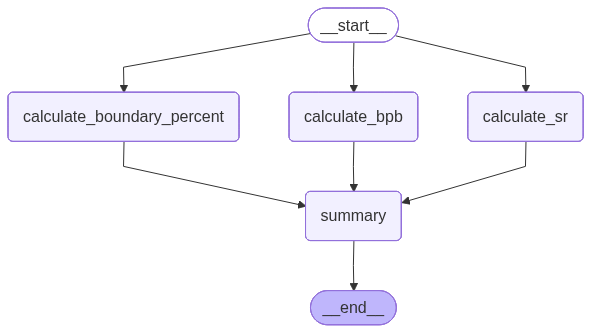

In [20]:
workflow

In [21]:
#Execution
initial_state = {
    'runs' : 100,
    'balls' : 50,
    'fours' :  6,
    'sixes' : 4
}
final_state = workflow.invoke(initial_state)

In [22]:
print(final_state)

{'runs': 100, 'balls': 50, 'fours': 6, 'sixes': 4, 'sr': 200.0, 'bpb': 5.0, 'boundary_percent': 48.0, 'summary': '\n    Strike Rate - 200.0\n\n    Balls per Boundary - 5.0\n\n    Boundary Percent - 48.0\n    '}
